# CSP Tutorial

This tutorial will show how to run filter bank CSP.

## Stuff just for notebook

In [2]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
matplotlib.rcParams['figure.figsize'] = (12.0, 1.0)
matplotlib.rcParams['font.size'] = 7

import logging
log = logging.getLogger()
log.setLevel('DEBUG')

## Imports

In [5]:
import numpy as np
import theano

import seaborn
seaborn.set_style('darkgrid')
from braindecode.datasets.loaders import BBCIDataset
from braindecode.datasets.signal_processor import SignalProcessor
from braindecode.mywyrm.clean import SingleSetCleaner, NoCleaner
from braindecode.csp.experiment import CSPExperiment
from braindecode.results.results import compute_confusion_matrix_csp
from braindecode.analysis.plot_util import plot_confusion_matrix

### Things to adapt for your dataset

In [6]:
filename = 'data/ekaterina_error_data/EcAnERN1_1-10.BBCI.mat'
#filename = 'data/BBCI-without-last-runs/BhNoMoSc1S001R01_ds10_1-12.BBCI.mat'
load_sensor_names_eog = ['EOG_R', 'EOG_L', 'EOG_U', 'EOG_D']
#load_sensor_names_eog = ['EOGv', 'EOGh']
marker_def = {'1 - Correct': [31], '2 - Error': [32]}
#marker_def = {'1 - Right Hand': [1], '2 - Left Hand': [2], 
#                    '3 - Rest': [3], '4 - Feet': [4]}

### Sensor parameters

In [9]:
# If you specify sensors here, other sensors will also not be used during cleaning
# -> you might get different rejected trials for different sensors.
# In case you dont want this, use sensor_names_after cleaning in the line below
load_sensor_names = ['C3','Cz', 'C4'] # None means all
set_loader = BBCIDataset(filename, load_sensor_names=load_sensor_names)
sensor_names_after_cleaning = None # none means all

### Cleaning parameters

In [10]:
#cleaner = SingleSetCleaner(eog_set=BBCIDataset(filename,
#    load_sensor_names=load_sensor_names_eog), marker_def=marker_def,
#            rejection_var_ival=[0,4000], 
#            rejection_blink_ival=[-500,4000],
#            max_min=600, whisker_percent=10, whisker_length=3)
# Or no cleaning:
cleaner = NoCleaner(marker_def=marker_def)

### CSP Parameters

In [13]:
# None here usually implies all :)

csp_experiment = CSPExperiment(set_loader, sensor_names=sensor_names_after_cleaning,
            cleaner=cleaner,
            resample_fs=150,
            min_freq=0, max_freq=48, last_low_freq=48, # filterbank params
            low_width=4, high_width=4,
            filt_order=3,
            segment_ival=[500,4000], # trial interval
            standardize=True, # standardize the data?..
            n_folds=5, 
            n_top_bottom_csp_filters=3, # this number times two will be number of csp filters per filterband before feature selection 
            n_selected_filterbands=None, # how many filterbands to select?
            n_selected_features=None, # how many Features to select with the feature selection?
            forward_steps=4,  # feature selection param
            backward_steps=2, # feature selection param
            stop_when_no_improvement=False, # feature selection param
            only_last_fold=True, # Split into number of folds, but only run the last fold (i.e. last fold as test fold)?
            restricted_n_trials=None, # restrict to certain number of _clean_ trials?
            common_average_reference=False,
            ival_optimizer=None, # optimize the trial ival with some optimizer?
            shuffle=False, # shuffle or do blockwise folds?
            marker_def=marker_def)

### Running the experiment

In [15]:
csp_experiment.run()

INFO:braindecode.csp.experiment:Loading set...
INFO:braindecode.csp.experiment:Cleaning set...
INFO:braindecode.csp.experiment:Preprocessing set...
INFO:braindecode.csp.experiment:Running Training...
INFO:braindecode.csp.pipeline:Filter 1/13, 0.50 to 2.00 Hz
INFO:braindecode.csp.pipeline:Fold Nr: 1
INFO:braindecode.csp.pipeline:Class 1 vs 2
INFO:braindecode.csp.pipeline:Train: 61.21%
INFO:braindecode.csp.pipeline:Test:  61.58%
INFO:braindecode.csp.pipeline:Filter 2/13, 2.00 to 6.00 Hz
INFO:braindecode.csp.pipeline:Fold Nr: 1
INFO:braindecode.csp.pipeline:Class 1 vs 2
INFO:braindecode.csp.pipeline:Train: 56.09%
INFO:braindecode.csp.pipeline:Test:  53.68%
INFO:braindecode.csp.pipeline:Filter 3/13, 6.00 to 10.00 Hz
INFO:braindecode.csp.pipeline:Fold Nr: 1
INFO:braindecode.csp.pipeline:Class 1 vs 2
INFO:braindecode.csp.pipeline:Train: 56.88%
INFO:braindecode.csp.pipeline:Test:  55.26%
INFO:braindecode.csp.pipeline:Filter 4/13, 10.00 to 14.00 Hz
INFO:braindecode.csp.pipeline:Fold Nr: 1
INFO

## Plotting confusion matrix

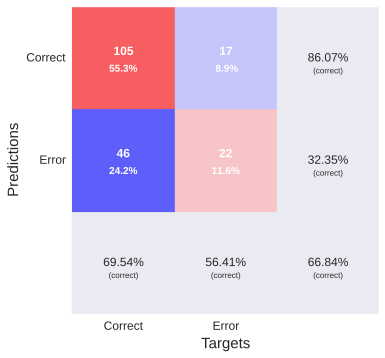

In [17]:
from braindecode.csp.results import CSPResult
from matplotlib import pyplot
class_names=['Correct', 'Error']
#class_names = ['Right', 'Left', 'Rest', 'Feet']
result = CSPResult(csp_experiment, csp_experiment.original_params, training_time=-1) # ignoring training time
conf_mat = compute_confusion_matrix_csp([result])

plot_confusion_matrix(conf_mat, class_names)
None

## Kappa Value

The Kappa value tells us how good the classifier is compared to a random classifier with the same distribution of predictions (same number of predictions per class).
0 is a random classifier and 1 is a perfect classifier.

In [18]:
# following http://stats.stackexchange.com/a/82187/56289 for the computation of the kappa value
n_trials = np.sum(conf_mat)
observed_accuracy = np.sum(np.diag(conf_mat)) / float(n_trials)
fractions = [] # don't know a better name for this
for i_class in range(conf_mat.shape[0]):
    product = np.sum(conf_mat[i_class]) * np.sum(conf_mat[:, i_class])
    fractions.append(product / float(n_trials))
expected_accuracy = sum(fractions) / float(n_trials)


print("Observed Accuracy:    {:5.2f}%".format(observed_accuracy * 100))
print("Expected Accuracy:    {:5.2f}%".format(expected_accuracy * 100))
print("Kappa:                {:5.2f}".format((observed_accuracy -expected_accuracy) /
                                             (1 - expected_accuracy)))

Observed Accuracy:    66.84%
Expected Accuracy:    58.38%
Kappa:                 0.20


## Ival optimizer

We can repeat the experiment with the ival optimizer.

In [19]:
from braindecode.csp.ival_optimizers import CorrCoeffIntervalOptimizer

In [26]:
csp_experiment.ival_optimizer = CorrCoeffIntervalOptimizer()

csp_experiment.run()


INFO:braindecode.csp.experiment:Loading set...
INFO:braindecode.csp.experiment:Cleaning set...
INFO:braindecode.csp.experiment:Preprocessing set...
INFO:braindecode.csp.experiment:Running Training...
INFO:braindecode.csp.pipeline:Filter 1/13, 0.50 to 2.00 Hz
INFO:braindecode.csp.pipeline:Fold Nr: 1
INFO:braindecode.csp.pipeline:Class 1 vs 2
INFO:braindecode.csp.pipeline:Ival 500 - 900
INFO:braindecode.csp.pipeline:Train: 67.37%
INFO:braindecode.csp.pipeline:Test:  61.58%
INFO:braindecode.csp.pipeline:Filter 2/13, 2.00 to 6.00 Hz
INFO:braindecode.csp.pipeline:Fold Nr: 1
INFO:braindecode.csp.pipeline:Class 1 vs 2
INFO:braindecode.csp.pipeline:Ival 500 - 4000
INFO:braindecode.csp.pipeline:Train: 56.09%
INFO:braindecode.csp.pipeline:Test:  53.68%
INFO:braindecode.csp.pipeline:Filter 3/13, 6.00 to 10.00 Hz
INFO:braindecode.csp.pipeline:Fold Nr: 1
INFO:braindecode.csp.pipeline:Class 1 vs 2
INFO:braindecode.csp.pipeline:Ival 500 - 2500
INFO:braindecode.csp.pipeline:Train: 58.19%
INFO:braindec

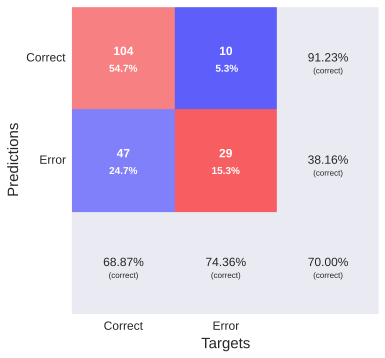

In [27]:
class_names=['Correct', 'Error']
#class_names = ['Right', 'Left', 'Rest', 'Feet']
result = CSPResult(csp_experiment, csp_experiment.original_params, training_time=-1) # ignoring training time
conf_mat = compute_confusion_matrix_csp([result])

plot_confusion_matrix(conf_mat, class_names)
None

In [28]:

# following http://stats.stackexchange.com/a/82187/56289 for the computation of the kappa value
n_trials = np.sum(conf_mat)
observed_accuracy = np.sum(np.diag(conf_mat)) / float(n_trials)
fractions = [] # don't know a better name for this
for i_class in range(conf_mat.shape[0]):
    product = np.sum(conf_mat[i_class]) * np.sum(conf_mat[:, i_class])
    fractions.append(product / float(n_trials))
expected_accuracy = sum(fractions) / float(n_trials)


print("Observed Accuracy:    {:5.2f}%".format(observed_accuracy * 100))
print("Expected Accuracy:    {:5.2f}%".format(expected_accuracy * 100))
print("Kappa:                {:5.2f}".format((observed_accuracy -expected_accuracy) /
                                             (1 - expected_accuracy)))

Observed Accuracy:    70.00%
Expected Accuracy:    55.89%
Kappa:                 0.32


Already better! :)

## Different filterbank

Now lets also try rerunning with a larger filterbank and feature selection.

In [30]:
csp_experiment.last_low_freq = 30
csp_experiment.max_freq = 82
csp_experiment.resample_fs = 200
csp_experiment.min_freq = 0
csp_experiment.low_width = 2
csp_experiment.high_width = 6
csp_experiment.n_selected_features = 20

In [31]:
csp_experiment.run()

INFO:braindecode.csp.experiment:Loading set...
INFO:braindecode.csp.experiment:Cleaning set...
INFO:braindecode.csp.experiment:Preprocessing set...
INFO:braindecode.csp.experiment:Running Training...
INFO:braindecode.csp.pipeline:Filter 1/25, 0.50 to 1.00 Hz
INFO:braindecode.csp.pipeline:Fold Nr: 1
INFO:braindecode.csp.pipeline:Class 1 vs 2
INFO:braindecode.csp.pipeline:Ival 2400 - 4000
INFO:braindecode.csp.pipeline:Train: 55.57%
INFO:braindecode.csp.pipeline:Test:  60.00%
INFO:braindecode.csp.pipeline:Filter 2/25, 1.00 to 3.00 Hz
INFO:braindecode.csp.pipeline:Fold Nr: 1
INFO:braindecode.csp.pipeline:Class 1 vs 2
INFO:braindecode.csp.pipeline:Ival 500 - 700
INFO:braindecode.csp.pipeline:Train: 57.54%
INFO:braindecode.csp.pipeline:Test:  58.42%
INFO:braindecode.csp.pipeline:Filter 3/25, 3.00 to 5.00 Hz
INFO:braindecode.csp.pipeline:Fold Nr: 1
INFO:braindecode.csp.pipeline:Class 1 vs 2
INFO:braindecode.csp.pipeline:Ival 500 - 700
INFO:braindecode.csp.pipeline:Train: 53.21%
INFO:braindeco

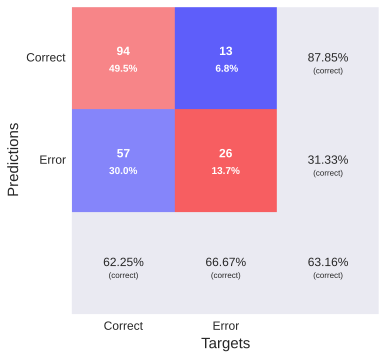

In [32]:
class_names=['Correct', 'Error']
#class_names = ['Right', 'Left', 'Rest', 'Feet']
result = CSPResult(csp_experiment, csp_experiment.original_params, training_time=-1) # ignoring training time
conf_mat = compute_confusion_matrix_csp([result])

plot_confusion_matrix(conf_mat, class_names)
None

In [33]:
# following http://stats.stackexchange.com/a/82187/56289 for the computation of the kappa value
n_trials = np.sum(conf_mat)
observed_accuracy = np.sum(np.diag(conf_mat)) / float(n_trials)
fractions = [] # don't know a better name for this
for i_class in range(conf_mat.shape[0]):
    product = np.sum(conf_mat[i_class]) * np.sum(conf_mat[:, i_class])
    fractions.append(product / float(n_trials))
expected_accuracy = sum(fractions) / float(n_trials)


print("Observed Accuracy:    {:5.2f}%".format(observed_accuracy * 100))
print("Expected Accuracy:    {:5.2f}%".format(expected_accuracy * 100))
print("Kappa:                {:5.2f}".format((observed_accuracy -expected_accuracy) /
                                             (1 - expected_accuracy)))

Observed Accuracy:    63.16%
Expected Accuracy:    53.72%
Kappa:                 0.20


Worse again :(

## Stuff for me (Robin)

In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2